# **Irene Dovichi** 
## Midterm 1 - Assignment 5
Perform image segmentation on all images in the dataset, using the normalized cut algorithm running on the top of superpixels rather than on raw pixels. For each image compute an accuracy metric (which one it is up to you to decide) measuring the overlap between the segments identified by NCUT and the ground truth horse semantic segmentation. Provide a table summarizing the average segmentation accuracy on all images, plus present 2 examples of images that are well-segmented (according to the above defined metric).

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, graph, io
from skimage.metrics import structural_similarity
import os
from tqdm import tqdm

## Dataset Loading
All the original images of the Weizmann Horse Database (link: www.kaggle.com/datasets/ztaihong/weizmann-horse-database/data) are saved in the list `images`. 

The corresponding masks are saved in the list `masks`.

In [2]:
path = './weizmann_horse_db/horse'
images = []
for file in sorted(os.listdir(path)):
    if os.path.isfile(os.path.join(path, file)):
        images.append(io.imread(os.path.join(path, file)))

In [3]:
path = './weizmann_horse_db/mask'
masks = []
for file in sorted(os.listdir(path)):
    if os.path.isfile(os.path.join(path, file)):
        masks.append(io.imread(os.path.join(path, file)))

In [20]:
# print element m of `images` and the corresponding element of `masks`
m = 97

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(images[m])
plt.title(f'Original Image: Horse {m}')

plt.subplot(1, 2, 2)
plt.imshow(masks[m])
plt.title(f'Mask: Horse {m}')
plt.show()

## Segmentation
The skimage implementation of SLIC algorithm was used to generate the superpixels of images. The parameters I focused on were:
- `compactness`, for which I tried the values: 0.01, 0.1, 1, 10
- `sigma`, for which I tried: 0, 1, 10, 100
- `n_parameters`, for which I tried: 100, 500

I also tried the zero parameter version SLICO.

### First approach
The first try I did was to convert the images to grayscale before performing the segmentation and clustering. Then, I will keep the colored images and discuss which approach gave the best results. 

In [24]:
# convert images to grayscale
gray_images = [color.rgb2gray(img) for img in images]

In [49]:
# compactness parameters
compactness = [0.01, 0.1, 1, 10]

# sigma parameters
sigma = [0, 1, 10, 100]

# number of segments
n_segments = [100, 500]

**!!! For timing reasons I select 10 random images and do the grid search for them.**

In [118]:
# select k random images 
k = 10
np.random.seed(42)
random_indexes = np.random.choice(len(images), k, replace=False)
random_images = []
gray_random_images = []
random_masks = []
for i in random_indexes:
    random_images.append(images[i])
    gray_random_images.append(gray_images[i])
    random_masks.append(masks[i])


In [119]:
# plot the random_images
plt.figure(figsize=(30,10))
for i in range(k):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_images[i])
    plt.title(f'Horse {random_indexes[i]}')

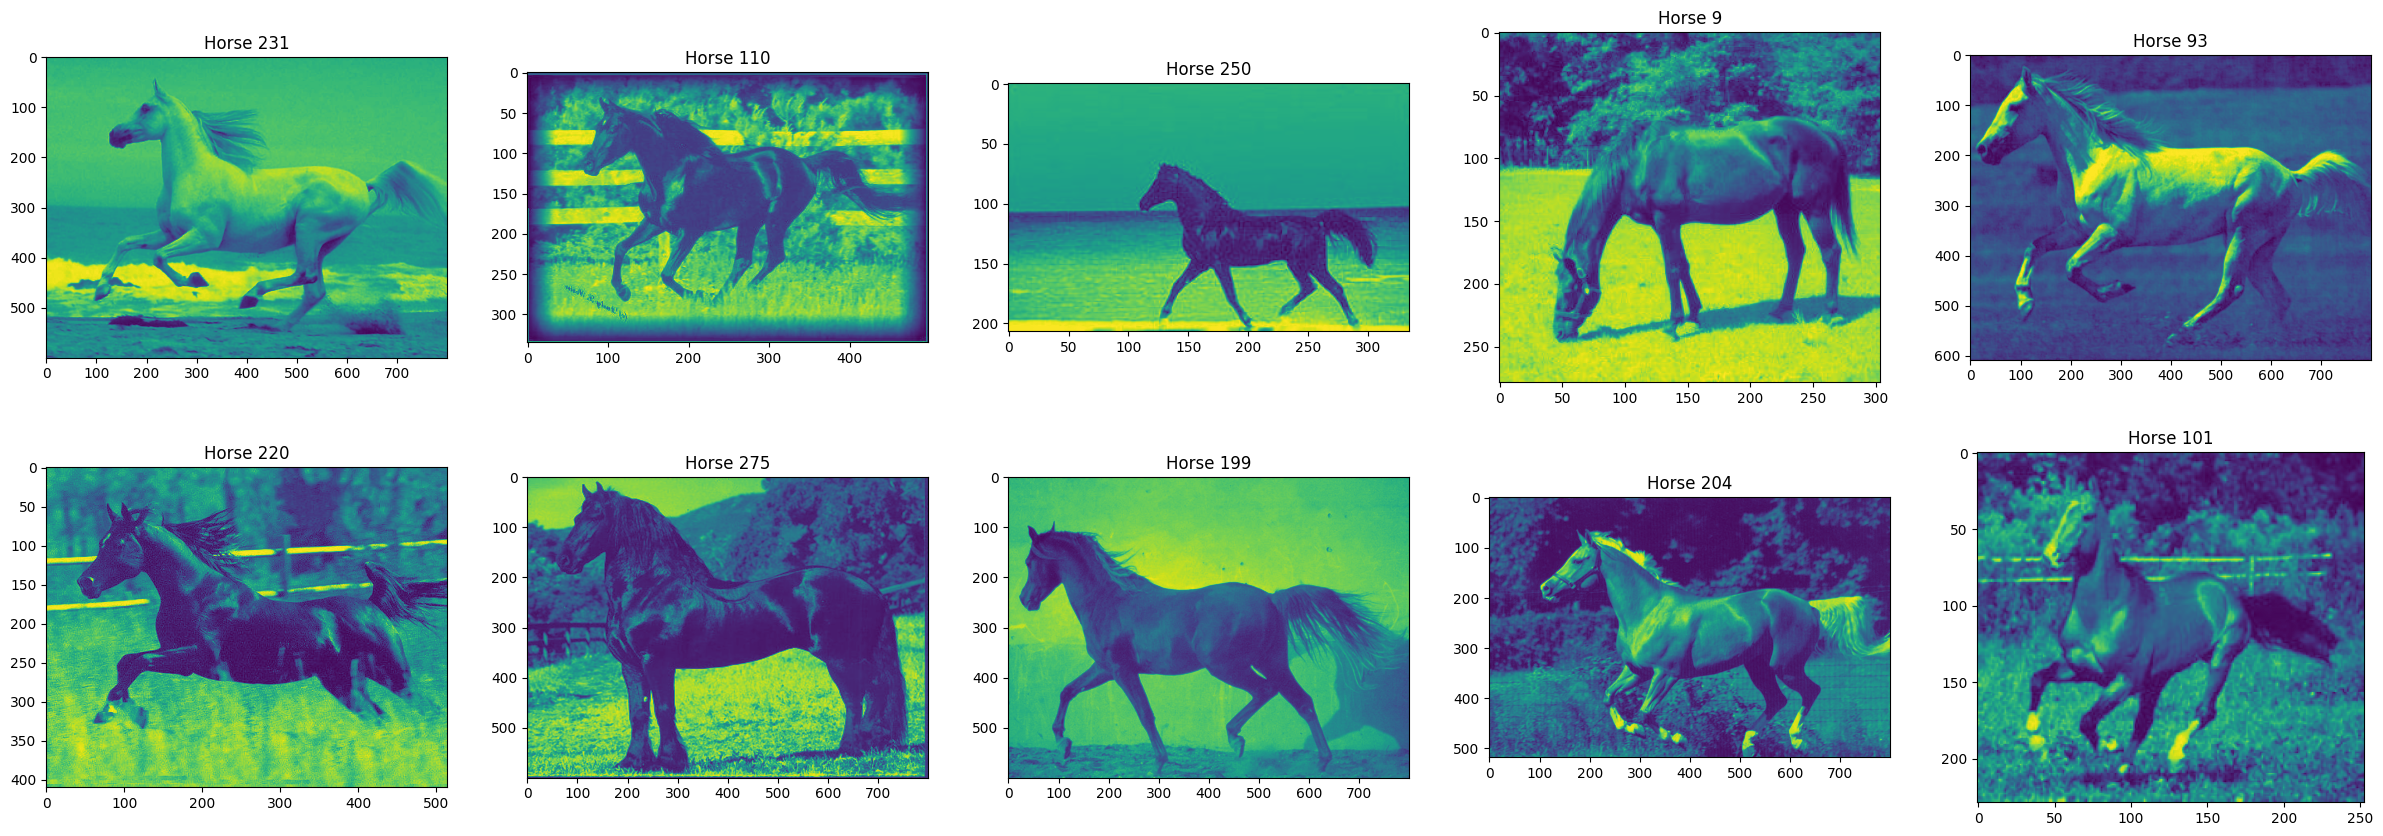

In [120]:
# plot the gray_random_images
plt.figure(figsize=(30,10))
for i in range(k):
    plt.subplot(2, 5, i+1)
    plt.imshow(gray_random_images[i])
    plt.title(f'Horse {random_indexes[i]}')

In [88]:
segmentation_results = []

# apply segmentation and ncut
for i in range(len(gray_random_images)): 
    image_results = []
    for c in compactness:
        for s in sigma:
            for n in n_segments:
                segments = segmentation.slic(gray_random_images[i], compactness=c, n_segments=n, sigma=s, channel_axis=None)
                g = graph.rag_mean_color(gray_random_images[i], segments, mode='similarity')
                cut = graph.cut_normalized(segments, g)
                # store results for this combination of parameters
                image_results.append((c, s, n, segments, cut))
    segmentation_results.append(image_results)

In [91]:
# for example, the segmentation of the first image, for the first combination of parameters (c,s,n) is:
segmentation_results[0][0][3]

array([[ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       ...,
       [40, 40, 40, ..., 43, 43, 43],
       [40, 40, 40, ..., 43, 43, 43],
       [40, 40, 40, ..., 43, 43, 43]])

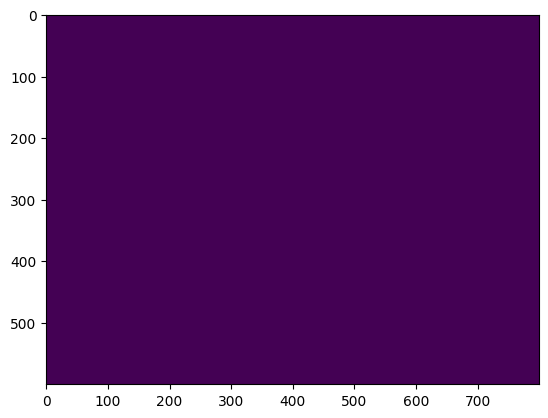

In [104]:
# for example, the plot of the segmentation of the first image, for the first combination of parameters (c,s,n) is:
plt.imshow(segmentation_results[7][31][4])

Segmentation accuracy: now let's compare the segmented regions obtained from normalized cut with ground truth segmentation masks. The chosen metrics are: 
- Intersection over Union (IoU)
- 

## Second approach
 apply segmentation to colored images.

In [121]:
segmentation_results = []

# apply segmentation and ncut
with tqdm(total=32*k, desc='loading', colour='yellow') as pbar:
    for i in range(len(random_images)): 
        image_results = []
        for c in compactness:
            for s in sigma:
                for n in n_segments:
                    segments = segmentation.slic(random_images[i], compactness=c, n_segments=n, sigma=s)
                    g = graph.rag_mean_color(random_images[i], segments, mode='similarity')
                    cut = graph.cut_normalized(segments, g)
                    # store results for this combination of parameters
                    image_results.append((c, s, n, segments, cut))
                    pbar.update(1)
        segmentation_results.append(image_results)

loading: 320it [08:58,  1.68s/it]                       3.11s/it]


In [122]:
# for example, the segmentation of the first image, for the first combination of parameters (c,s,n) is:
segmentation_results[0][0][3]

array([[ 1,  1,  1, ...,  4,  4,  4],
       [ 1,  1,  1, ...,  4,  4,  4],
       [ 1,  1,  1, ...,  4,  4,  4],
       ...,
       [49, 49, 49, ..., 48, 48, 48],
       [49, 49, 49, ..., 48, 48, 48],
       [49, 49, 49, ..., 48, 48, 48]])

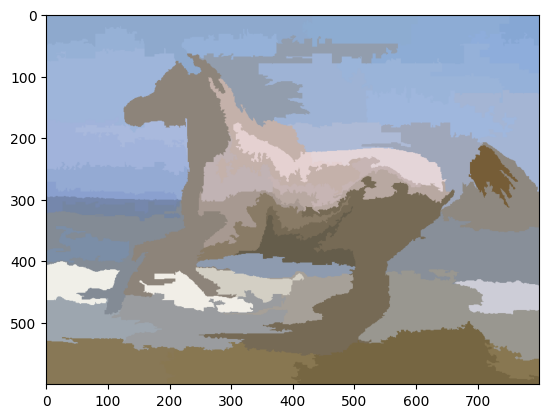

In [123]:
# we can also use average of the pixels (in the corresponding superpixel) to color the superpixel
colored = color.label2rgb(segmentation_results[0][0][3], random_images[0], kind='avg')
plt.imshow(colored)

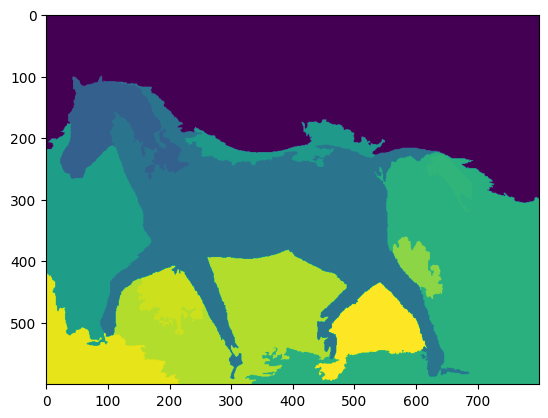

In [127]:
plt.imshow(segmentation_results[7][10][4])

Segmentation accuracy: now let's compare the segmented regions obtained from normalized cut with ground truth segmentation masks. 

The chosen metrics are: 
- Intersection over Union $$IoU(A,B) = \frac{|A \cap B|}{|A \cup B|}$$ 
- Structural Similarity Index Measure (SSIM)

In [128]:
def IoU(segments, mask):
    intersection = np.logical_and(segments, mask)
    union = np.logical_or(segments, mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

Since the comparison is done with the masks, which have only 2 colors, I decided to reduce the cut to a 2-colors image. So, I converted the multi-class segmentation result into a binary mask by thresholding the pixel values. 

In [132]:
iou_results = []

for image_results in range(len(segmentation_results)):
    iou_image_results = []
    for param in range(len(segmentation_results[image_results])):
        iou = IoU(segmentation_results[image_results][param][3], random_masks[image_results])
        iou_image_results.append(iou)
    iou_results.append(iou_image_results)

In [142]:
# value counts of iou_results[0]
np.unique(iou_results[0], return_counts=True)

(array([0.25580417]), array([32]))

SSIM

In [151]:
ssim_results = []

for image_results in range(len(segmentation_results)):
    ssim_image_results = []
    for param in range(len(segmentation_results[image_results])):
        data_range = np.max(segmentation_results[image_results][param][3]) - np.min(segmentation_results[image_results][param][3])
        ssim = structural_similarity(
            segmentation_results[image_results][param][3], 
            random_masks[image_results],
            data_range=data_range
            )
        ssim_image_results.append(ssim)
    ssim_results.append(ssim_image_results)

In [146]:
segmentation_results[0][param][3].shape

(600, 800)

In [149]:
# compute the data range of the segmentation_results[0] image (distance between minimum and maximum possible values):
data_range = np.max(segmentation_results[0][param][3]) - np.min(segmentation_results[0][param][3])

In [150]:
data_range

493

In [148]:
random_masks[0].shape

(600, 800)

In [153]:
# value counts of ssim_results[0]
np.unique(ssim_results[7], return_counts=True)

(array([0.010454  , 0.01286762, 0.01323816, 0.01334056, 0.01342612,
        0.01452948, 0.01470522, 0.01509514, 0.01521236, 0.01796428,
        0.01816355, 0.01826104, 0.02049357, 0.02052427, 0.02062557,
        0.02079714, 0.0219597 , 0.0219608 , 0.0221091 , 0.02261066,
        0.0230473 , 0.02355558, 0.02355729, 0.0236137 , 0.02438082,
        0.02502614, 0.02507517, 0.02510487, 0.02548771, 0.03068827,
        0.07296792, 0.08196577]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

### Zero parameters version

## Valutation

## Results & Analysis

In [ ]:
# summarizing table

## Personal Considerations

In [ ]:
# fun things, weak aspects, possible ways to enhance the analysis, etc.